<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Otimiza%C3%A7%C3%A3o_Ag_pol%C3%ADtica_de_manuten%C3%A7%C3%A3o_preventiva_imperfeita_v13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [181]:
%%capture
pip install geneticalgorithm

In [182]:
%%capture
pip install memory-profiler

In [183]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import csv
import math
from geneticalgorithm import geneticalgorithm as ga
from scipy.optimize import differential_evolution
from memory_profiler import profile
import locale

In [184]:
!dpkg-reconfigure locales

Generating locales (this might take a while)...
  en_US.UTF-8... done
  pt_BR.ISO-8859-1... done
Generation complete.


In [185]:
# Install locale pt_BR
!/usr/share/locales/install-language-pack pt_BR

Generating locales (this might take a while)...
Generation complete.
dpkg-trigger: error: must be called from a maintainer script (or with a --by-package option)

Type dpkg-trigger --help for help about this utility.


In [186]:
print(locale.getlocale())

('pt_BR', 'ISO8859-1')


In [187]:
locale.setlocale(locale.LC_ALL, 'pt_BR.iso88591')

'pt_BR.iso88591'

In [188]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [189]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 10000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 730 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 4000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_ag/'
NOME_ARQUIVO_PRINCIPAL = 'melhor_custo_ag_primeiro_cenario'
NOME_ARQUIVO_TEMPO_SEVERIDADE = '_tempo_severidade'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO = '01'

In [190]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
          # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break

    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha $\it{u(t)}$")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [191]:
class FuncaoConfiabilidade:
    # Este método vai inicializar cada objeto criado a partir desta classe
        # O nome deste método é __init__
        # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
        #
        # Atributos de cada objeto criado a partir desta classe.
        # O self indica que estes são atributos dos objetos
    def __init__(self, T, s, solucao, last_failure):
        self.reducao = 'Idade'
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T
        self.s = [[0] + s[0]]

        print('Fator de reducao:', self.reducao)

        # Função de Confiabilidade
        self.R = []
        tn = last_failure
        Tc = self.T[-1]
        c = len(self.T)

        # severidade da última MP
        severidade = self.s[-1][-1]

        # Fator da ultima MP
        fator_final = self.s[-1][-1]

        for t in range(self.sz):
            a = fator_final
            val = ((1 / (self.lamb ** self.beta)) * ((tn + t - a * Tc) ** self.beta) - ((1 / (self.lamb ** self.beta)) * ((tn - a * Tc) ** self.beta)))
            val = math.exp(-val)
            self.R.append(val)

    def plotConfiabilidade(self, fator):
        fig = plt.figure()
        plt.plot(self.R)
        plt.xlabel("Tempo $\it{t}$ (dias)")
        plt.ylabel("Confiabilidade $\it{R(t)}$")
        plt.show()

        fileName = 'Rt_' + self.reducao + str(fator)
        fig.savefig(fileName, dpi=300, bbox_inches="tight", facecolor='w', edgecolor='w')

In [192]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [193]:
# efine a função de melhoria Linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j]*theta)
        fator.append(linha)
    return fator

In [194]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - math.exp(-s[k][j]*theta))
        fator.append(linha)
    return fator

In [195]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [196]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [197]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [198]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [199]:
# Função custo de manutenção baseada severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {

        0.20: 2000,

        0.40: 4000,
        0.50: 9000,

        0.90: 12000,

        }
    cmp_f = dist[s]
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US
17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US 2.000 e US
3.000, respectivamente e MC fixa em US$15.000 texto em itálico

In [200]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/cenario{CENARIO}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0


* t: Representa os tempos de falha.
* k: Indica o índice do sistema.
* c: Representa o número de ciclos de manutenção.
* n: Indica o número de falhas em cada ciclo de manutenção preventiva.
* s: Representa a severidade das manutenções preventivas em cada sistema.
* T: Indica os tempos das manutenções preventivas.

In [201]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [202]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[0]
    beta = x[1]
    theta = x[2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [203]:
# Ajusta o modelo com base nos dados lidos
def adjust_model():
    global model_adjusted
    model_adjusted = True

    varbound = np.array([[100, 150], [1, 2], [0, 1]])

    algorithm_param = {
        'max_num_iteration': 50,
        'population_size': 100,
        'mutation_probability': 0.05,
        'elit_ratio': 0.01,
        'crossover_probability': 0.75,
        'parents_portion': 0.3,
        'crossover_type': 'two_point',
        'max_iteration_without_improv': None
    }

    model = ga(
        function=objective,
        dimension=3,
        variable_type='real',
        variable_boundaries=varbound,
        algorithm_parameters=algorithm_param,
        convergence_curve=False,
        progress_bar=False
    )

    # Registre o tempo de início de convergência para a primeira etapa
    start_time_first_stage = time.time()

    model.run()


    # Registre o tempo de término
    end_time_first_stage = time.time()

    # Calcule o tempo total de convergência
    convergence_time_first_stage = end_time_first_stage - start_time_first_stage

    res = model.best_variable

    lamb = res[0]
    beta = res[1]
    theta = res[2]

    return lamb, beta, theta, convergence_time_first_stage

In [204]:
# Variáveis Globais
model_adjusted = False

In [205]:
# Ajusta o modelo
lamb, beta, theta, convergence_time_first_stage = adjust_model()
print(f'lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

 The best solution found:
 [123.96477478   1.98991267   0.17562174]

 Objective function:
 -2.1261882191086156e-24
lamb: 123.9647747775835
beta: 1.9899126691584055
theta: 0.1756217407792264

Tempo de Convergência para a primeira etapa: 1.742079734802246 segundos


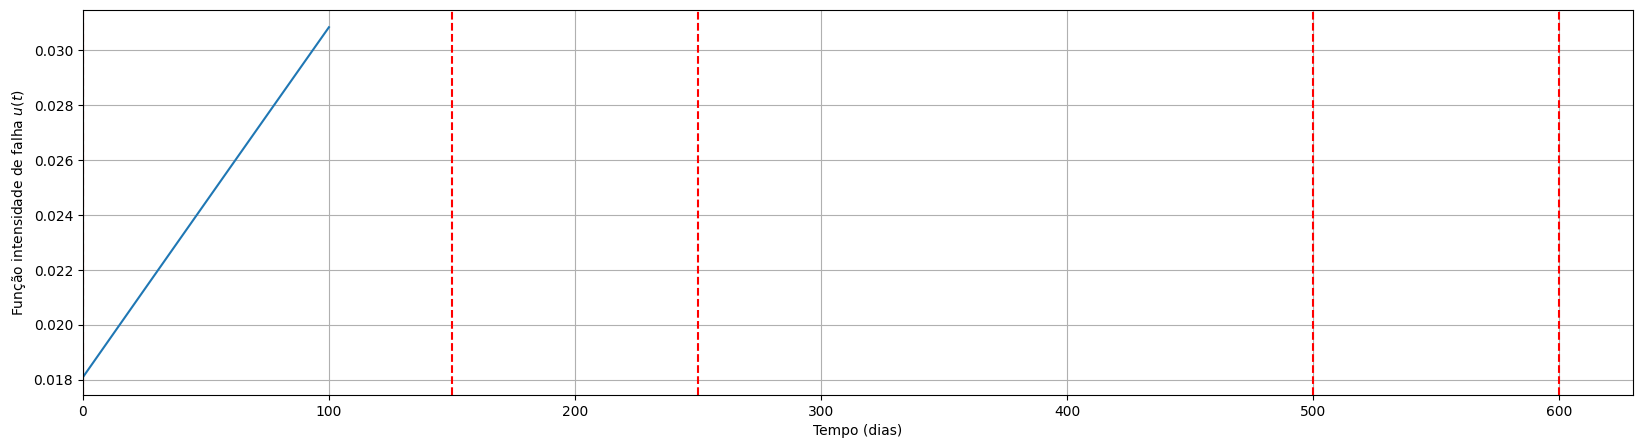

Fator ajuste:  [0.06783803416628409, 0.08406590939943193, 0.14620107753165767, 0.034514647530209386]


In [206]:
# lamb = 149.49576004448562
# beta = 5.051869901420757
# theta = 0.9138502982364278

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

# Etapa 2: Otimização

In [207]:
# Configurar a formatação da moeda
def format_currency(value):
    return locale.currency(value, grouping=True)

In [208]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]

def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {
        1: 0.20,
        3: 0.40,
        5: 0.50,
        7: 0.90,

        }

    results = [] # Lista para armazenar os resultados das funções objetivo

    global s
    T = [0]
    s_row = []
    cont = 0

    for number in x:
        modulo = int(number) % 2
        if modulo == 1:
            inteiro = int(number)
            s_row.append(dict_severidades[inteiro])  # Severidade
            frac = number - inteiro  # Tempo
            t = (cont + frac) * 30
            T.append(int(t))
        cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        if (T[i+1] - T[i]) != 0:
            Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
        else:
            Ctotal.append(float('inf'))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    custo = np.sum(Ctotal)
    results.append(custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

Aplica AG para determinar tempos e severidades



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 73, 111, 213, 349, 419, 424, 550, 628, 635, 714]
Severidade para cada subsistema: [0.9, 0.2, 0.4, 0.2, 0.9, 0.2, 0.5, 0.5, 0.4, 0.4]
Número de Sisemas: 5
Fator:  [0.034514647530209386, 0.14620107753165767, 0.034514647530209386, 0.06783803416628409, 0.034514647530209386, 0.14620107753165767, 0.034514647530209386, 0.08406590939943193, 0.08406590939943193, 0.06783803416628409, 0.06783803416628409]
Media de falhas:  [0, 0.3486333805857819, 0.7903506854482654, 2.712164198632542, 7.492466026115414, 10.72354847031312, 10.983944454796172, 17.832424811895073, 23.501766721175887, 24.01823522470819, 30.26961568591609, 31.64151091342484]
Custo =  4038.523942487185


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 91, 188, 251, 273, 312, 365, 392, 526, 552, 600, 663]
Severidade para cada subsistema: [0.9, 0.5, 0.9, 0.2, 0.9, 0.4, 0.9, 0.9, 0.5, 0.9, 0.4]
Número de Sisemas: 5
Fator:  [0.0345

/usr/local/lib/python3.10/dist-packages/geneticalgorithm/geneticalgorithm.py:353: RuntimeWarning: invalid value encountered in subtract
  normobj=maxnorm-normobj+1


A saída de streaming foi truncada nas últimas 5000 linhas.
Severidade para cada subsistema: [0.2, 0.4, 0.9]
Número de Sisemas: 5
Fator:  [0.034514647530209386, 0.034514647530209386, 0.06783803416628409, 0.14620107753165767]
Media de falhas:  [0, 0.7186367027401056, 0.9917305769315903, 9.630108278632648, 32.77300259413059]
Custo =  797.0206793872514


Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 105, 244]
Severidade para cada subsistema: [0.2, 0.4]
Número de Sisemas: 5
Fator:  [0.034514647530209386, 0.034514647530209386, 0.06783803416628409]
Media de falhas:  [0, 0.7186367027401056, 3.7834604488255343, 33.48078752082795]
Custo =  416.0504982655258


Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 105, 145, 390]
Severidade para cada subsistema: [0.2, 0.5, 0.9]
Número de Sisemas: 5
Fator:  [0.034514647530209386, 0.034514647530209386, 0.08406590939943193, 0.14620107753165767]
Media de falhas:  [0, 0.7186367027401056, 1.3474227252

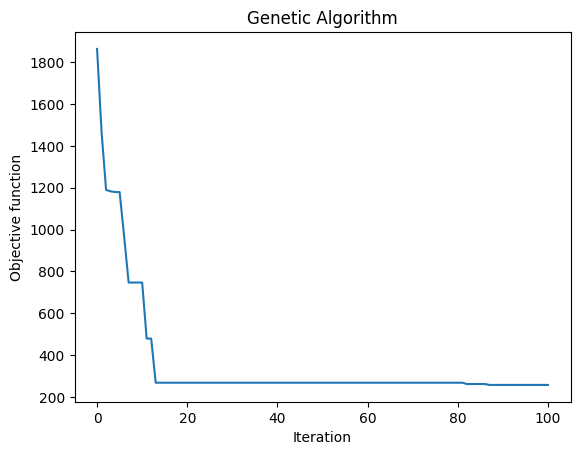

In [209]:
# Otimização da política de manutenção com AG
dimension = 24
varbound = np.array([[0, 8]] * 24)

algorithm_param_ = {
    'max_num_iteration': 100,\
    'population_size': 100,\
    'mutation_probability': 0.05,\
    'elit_ratio': 0.01,\
    'crossover_probability': 0.75,\
    'parents_portion': 0.3,\
    'crossover_type': 'two_point',\
    'max_iteration_without_improv': None
}

model_=ga(
    function = objective_st,
    dimension = dimension,
    variable_type = 'real',
    variable_boundaries = varbound,
    algorithm_parameters = algorithm_param_
)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

model_.run()

# Registre o tempo de término
end_time_second_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

In [210]:
# Coletar as melhores posições
best_positions = np.array(model_.output_dict['variable'])

In [211]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 123.9647747775835
beta: 1.9899126691584055
theta: 0.1756217407792264
Tempo de Convergência para a primeira etapa: 1.742079734802246 segundos


In [212]:
melhorCusto = format_currency(model_.output_dict['function'])
print(melhorCusto)

R$ 256,86


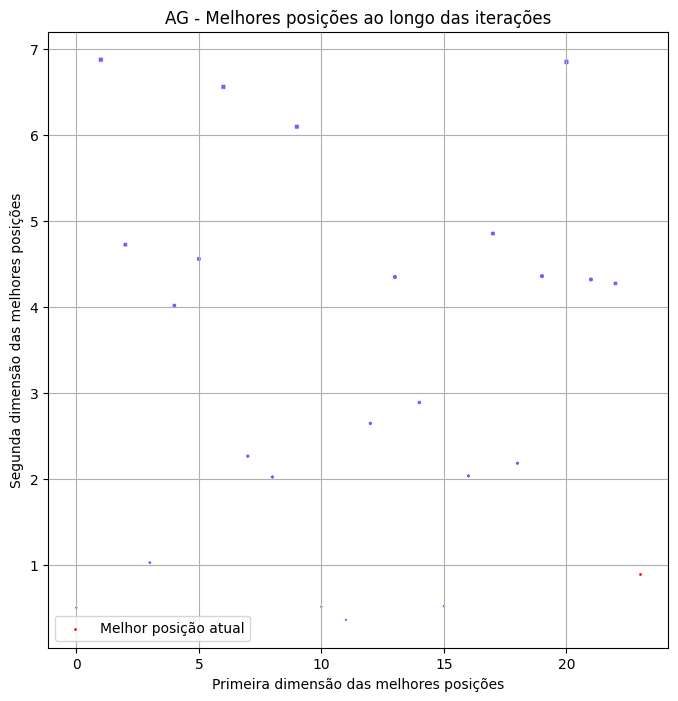


Número total de iterações: 100
Tamanho da população: 100
Número de Dimensões: 24
Melhor Custo: R$ 256,86
Tempo de Convergência para a segunda etapa: 90.07630586624146 segundos


In [213]:
# Plotar o gráfico 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Usar o índice das iterações como coordenada x
x = np.arange(best_positions.shape[0])

# Plotar todas as melhores posições anteriores
ax.scatter(x[:-1], best_positions[:-1], best_positions[:-1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(x[-1], best_positions[-1], best_positions[-1], c='red', label='Melhor posição atual')

ax.set_title('AG - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

print("")
print("Número total de iterações:", algorithm_param_['max_num_iteration'])
print("Tamanho da população:", algorithm_param_['population_size'])
print("Número de Dimensões:", dimension)
print("Melhor Custo:", melhorCusto)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

In [214]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

In [215]:
# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(linha[1])
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

melhores_custos_anteriores.append(melhorCusto)

# Criar uma lista com os valores atuais
valores_atuais = [len(melhores_custos_anteriores), melhorCusto, lamb, beta, theta, convergence_time_first_stage, convergence_time_second_stage,]

# Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Se o arquivo estiver vazio, escreva o cabeçalho
    if arquivo_csv.tell() == 0:
        writer.writerow(['Index', 'Melhor_Custo', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa', 'Ciclos_MP'])

    # Escrever os valores atuais
    writer.writerow(valores_atuais)

In [216]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo, sep=",")
resultado.head(10)

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,"R$ 249,22",125.244269,1.989799,0.045221,1.417979,65.728934,NaN
1,2,"R$ 256,86",123.964775,1.989913,0.175622,1.742080,90.076306,NaN


In [217]:
resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Index                        2 non-null      int64  
 1   Melhor_Custo                 2 non-null      object 
 2   Lambda                       2 non-null      float64
 3   Beta                         2 non-null      float64
 4   Theta                        2 non-null      float64
 5   Convergencia_Primeira_Etapa  2 non-null      float64
 6   Convergencia_Segunda_Etapa   2 non-null      float64
 7   Ciclos_MP                    0 non-null      float64
dtypes: float64(6), int64(1), object(1)
memory usage: 256.0+ bytes


In [218]:
resultado.describe()

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.0
mean,1.500000,124.604522,1.989856,0.110421,1.580029,77.902620,NaN
std,0.707107,0.904739,0.000080,0.092207,0.229174,17.216192,NaN
min,1.000000,123.964775,1.989799,0.045221,1.417979,65.728934,NaN
25%,1.250000,124.284648,1.989828,0.077821,1.499004,71.815777,NaN
50%,1.500000,124.604522,1.989856,0.110421,1.580029,77.902620,NaN
75%,1.750000,124.924395,1.989884,0.143022,1.661055,83.989463,NaN
max,2.000000,125.244269,1.989913,0.175622,1.742080,90.076306,NaN


In [219]:
param_primeira_etapa = ['Lambda', 'Beta', 'Theta']
param_segunda_etapa = ['Ciclos_MP', 'Melhor_Custo']
convergencia = ['Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa']
Melhor_Custo = ['Melhor_Custo']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

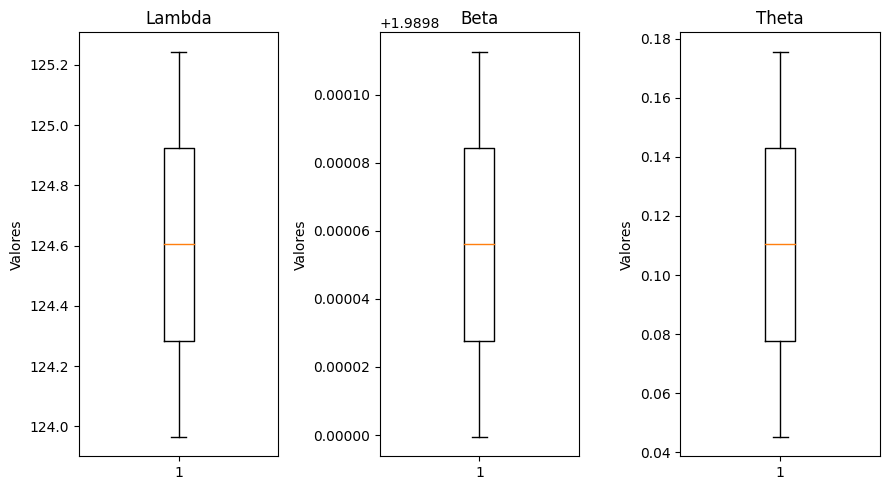

In [220]:
# Cria uma grafico para os parametros Lambda, Beta e Theta
# Tamanho da figura
plt.figure(figsize=(9, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_primeira_etapa):
    plt.subplot(1, 3, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

TypeError: ignored

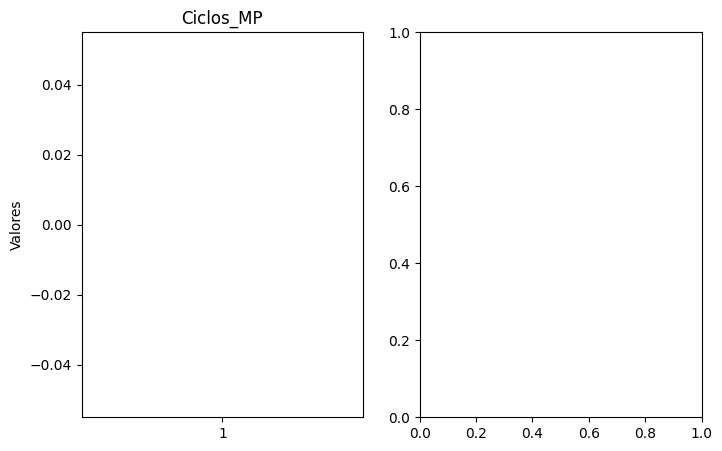

In [221]:
# Cria uma grafico para os parameros da segunda etapa
# Tamanho da figura
plt.figure(figsize=(8, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_segunda_etapa):
    plt.subplot(1, 2, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [ ]:
# Cria uma grafico para comparar as convervencias da primeira e segunda etapa
# Tamanho da figura
plt.figure(figsize=(8, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(convergencia):
    plt.subplot(1, 2, i + 1)  # 1 linhas, 2 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [ ]:
# Seus arrays de tempos e severidade
Tempos = [
    [[137, 259, 380, 536]],
    [[153, 291, 426, 539]],
    [[118, 240, 356, 523]],
    [[199, 360, 526]],
    [[147, 273, 359, 509]],
    [[145, 273, 378, 514]],
    [[195, 354, 518]],
    [[188, 350, 520]],
    [[129, 242, 356, 523]],
    [[125, 237, 390, 534]],
]

severidade = [
    [[1.0, 1.0, 1.0, 0.25]],
    [[1.0, 1.0, 1.0, 0.25]],
    [[1.0, 1.0, 1.0, 0.25]],
    [[1.0, 1.0, 0.25]],
    [[1.0, 1.0, 1.0, 0.25]],
    [[1.0, 1.0, 1.0, 0.25]],
    [[1.0, 1.0, 0.5]],
    [[1.0, 1.0, 0.5]],
    [[1.0, 1.0, 1.0, 0.25]],
    [[1.0, 1.0, 1.0, 0.25]],
]

# Verifique se ambos os arrays têm o mesmo número de linhas
if len(Tempos) == len(severidade):
    with open(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', "w") as file:
        file.write('Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
        for i in range(len(Tempos)):
            row = Tempos[i] + severidade[i]
            row_str = [str(value) for value in row]
            file.write(f"{i};{';'.join(row_str)}\n")
else:
    print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")

In [ ]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', sep=";")
dados.head(10)

In [ ]:
dados.info()

In [ ]:
dados.describe()